In [1]:
import pandas as pd
import getpass
from sqlalchemy import create_engine
from sqlalchemy.exc import ResourceClosedError

In [2]:

class MySQLConnection:
    def __init__(self,user,hostname,db):
        self.user = str(user)
        self.hostname = str(hostname)
        self.db = str(db)
        pword = getpass.getpass("Enter password for user {}".format(user))
        # self.cnx = mysql.connector.connect(host=self.hostname,user=self.user, password=pword,database=self.db)
        self.engine = create_engine("mysql+mysqlconnector://{}:{}@{}/{}".format(user,pword,hostname,db))
        self.cnx = self.engine.connect()
    
    def write_to_db(self, df, table_name):
        try:
            df.to_sql(table_name,con = self.cnx,if_exists='fail',index=False)
        except Exception as e:
            print("\n SQL Write error with: ")
            print(df,"\n", e)
    
    def query(self,q):
        try:
            res = pd.read_sql(q,self.cnx)
            return res
        except ResourceClosedError:
            print("Query success, nothing was returned")

In [3]:
sql = MySQLConnection('oskars_s','ec2-13-53-137-109.eu-north-1.compute.amazonaws.com','classicmodels')

Enter password for user oskars_s········


In [ ]:
sql.query("drop table join_rezultats")

In [ ]:
sql.query("select * from orders")

In [ ]:
sql.query("select * from customers")

In [ ]:
sql.query("drop table join_rezultats")

In [ ]:
# 4. Katrā pilsētā ir tieši viens kurjers, cik piegāžu būs jāveic katram kurjeram?
# sql.query("SELECT * from orders")

# No sākuma, tabulas apvienosim un rezultātu ievietosim jaunā tabulā
q = """
create table join_rezultats as 
select 
    customers.customer_id,
    customers.address,
    customers.city,
    customers.state,
    orders.order_id,
    orders.amount
from 
    customers right join orders on 
    customers.customer_id = orders.customer_id
where 
    state is not NULL
"""
sql.query(q)

In [ ]:
sql.query("select * from join_rezultats order by city")

In [ ]:
# Mums bija jāizdara vairāki selekti, lai izveidotu jaunas 'tabulas'. 
# Tik, cik ir pilsētu.
# Un tad jāsaskaita cik ierakstu / piegāžu ir katrā šajā 'tabulā'

# Šo darbību var automatizēt izmantojot GROUP BY

# GROUP BY  
GROUP BY veic grupēšanu pa kādas kolonnas unikālajām vērtībām un aprēķina kādu 'kopsavilkuma' funkciju katrai šai grupai.  

Piemēram, ja mums ir tabula, kurā ir 15 rindiņas un  3 kolonnas a, b un c, kur c kolonnā ir divas unikālas vērtības, tad GROUP BY pēc c kolonnas, mums izveidos divas grupas. Viena katrai unikālajai c vērtībai. Uz šīm grupām tad obligāti ir jāuzliek kāda kopsavilkuma funkcija.  

Lietojamās kopsavilkuma funkcijas ir sekojošās:  
* COUNT  
* SUM  
* AVG  
* MIN  
* MAX  
Atkarībā no specifiskās SQL versijas, ko lietojat, šajā sarakstā var arī būt vēl kādas funkcijas

In [ ]:
q2 = """
select 
    city,
    count(*) as piegazu_skaits
from 
    join_rezultats
group by
    city
"""
sql.query(q2)

In [11]:
# Uzdevums:
# 1. Resetojiet kerneli, lai izveidotu jaunu sql objektu, iestādiet datubāzi uz classicmodels. 
# Visi sekojošie uzdevumi būs ar datubāzi classicmodels un ir jāpēta datubāzes modelis, lai tos izdomātu.

# sql = MySQLConnection('ubuntu','localhost','classicmodels')

# 2. Izpētiet datubāzes classicmodels shēmu. 
# Saskaitiet cik piegāžu ir katrā pilsētā, 

sql.query("describe customers")


# izmantojot tabulas customers un orders no datubāzes classicmodels.

,Field,Type,Null,Key,Default,Extra
0,customerNumber,int(11),NO,PRI,None,
1,customerName,varchar(50),NO,,None,
2,contactLastName,varchar(50),NO,,None,
3,contactFirstName,varchar(50),NO,,None,
4,phone,varchar(50),NO,,None,
5,addressLine1,varchar(50),NO,,None,
6,addressLine2,varchar(50),YES,,None,
7,city,varchar(50),NO,,None,
8,state,varchar(50),YES,,None,
9,postalCode,varchar(15),YES,,None,


In [12]:
sql.query("describe orders")

,Field,Type,Null,Key,Default,Extra
0,orderNumber,int(11),NO,PRI,None,
1,orderDate,date,NO,,None,
2,requiredDate,date,NO,,None,
3,shippedDate,date,YES,,None,
4,status,varchar(15),NO,,None,
5,comments,text,YES,,None,
6,customerNumber,int(11),NO,MUL,None,


In [16]:
grpq = """
select 
    city, 
    count(*) as skaits
from 
    customers join orders on 
    orders.customernumber = customers.customernumber 
group by 
    city
order by 
    skaits desc
limit 
    10
"""
sql.query(grpq)

,city,skaits
0,Madrid,31
1,San Rafael,17
2,NYC,16
3,Auckland,12
4,Paris,9
5,Singapore,9
6,Brickhaven,8
7,San Francisco,7
8,Nantes,7
9,New Bedford,6


In [21]:
# Uzdevums:
# Saskaitiet cik ir produktu līniju un cik katrā produktu līnijā ir unikālu produktu.
# sql.query("select count(distinct productline) from products")
sql.query("select productline, count(*) from products group by productline")

,productline,count(*)
0,Classic Cars,38
1,Motorcycles,13
2,Planes,12
3,Ships,9
4,Trains,3
5,Trucks and Buses,11
6,Vintage Cars,24


In [24]:
# sql.query("select productline, count(distinct productvendor) from products group by productline")

,productline,count(distinct productvendor)
0,Classic Cars,13
1,Motorcycles,10
2,Planes,9
3,Ships,7
4,Trains,3
5,Trucks and Buses,10
6,Vintage Cars,13


In [ ]:
# Uzdevums:
# Aprēķiniet cik daudz ienākumu ir no katras produktu līnijas

In [31]:
#Uzdevums:
# Aprēķiniet cik ir ienākumu no katras pilsētas
q3 = """
select
    city,
    sum(amount) as ienakumi
from 
    payments right join customers on
    payments.customernumber = customers.customernumber
group by
    city
order by 
    ienakumi desc
"""

a = sql.query(q3)

# Vairāku līmeņu SELECT  
Bieži rodās situācijas, kad mēs nevaram iegut nepieciešamos datus apvienojot tikai divas tabulas. 

In [36]:
q4 = """create table pasutijumu_ienakumi as 
select
    orders.customernumber,
    orderdetails_w_income.income
from 
    orderdetails_w_income join orders on
    orderdetails_w_income.ordernumber = orders.ordernumber
    """
sql.query(q4)

,customernumber,income
0,363,4080.00
1,363,2754.50
2,363,1660.12
3,363,1729.21
4,128,2701.50
...,...,...
2991,119,6261.71
2992,119,986.42
2993,119,3435.39
2994,119,553.52


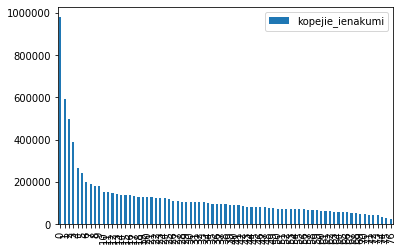

In [35]:
q3 = """
select 
    sum(income) as kopejie_ienakumi,
    city
from 
    customers join 
    (
    select
        orders.customernumber,
        orderdetails_w_income.income
    from 
        orderdetails_w_income join orders on
        orderdetails_w_income.ordernumber = orders.ordernumber
    ) pasutijumu_ienakumi on 
    customers.customernumber = pasutijumu_ienakumi.customernumber
group by
    city
order by 
    kopejie_ienakumi desc
"""


# test_q = """
# select
#     customernumber,
#     income
# from 
#     orderdetails_w_income join orders on
#     orderdetails_w_income.ordernumber = orders.ordernumber
# """
sql.query(q3).plot.bar()

Vispārīga sintakse iekšējo joinu veidošanai:  


In [37]:
"""
SELECT
    kolonna1,
    kolonna2
FROM 
    areja_joina_tabula <join tips> join 
    (
        
    <
    SELECT statements un/vai joins, 
    kas atgriež tabulu, kura satur indeksu, 
    ko var sasaistīt ar tabulu areja_join_tabula 
    >

    ) iekseja_join_tabula on 
    areja_join_tabula.indeksa_kolonna = iekseja_join_tabula.indeksa_kolonna_velams_nosaukta_citadi
"""

'\nSELECT\n    kolonna1,\n    kolonna2\nFROM \n    areja_joina_tabula <join tips> join \n    (\n        \n    <\n    SELECT statements un/vai joins, \n    kas atgriež tabulu, kura satur indeksu, \n    ko var sasaistīt ar tabulu areja_join_tabula \n    >\n\n    ) iekseja_join_tabula on \n    areja_join_tabula.indeksa_kolonna = iekseja_join_tabula.indeksa_kolonna_velams_nosaukta_citadi\n'

Praktiski padomi strādājot ar vairākiem joiniem:  
* Izmantojiet aliasus
* Vienmēr iztestējiet iekšējo joinu kā pirmo. Pārbaudiet vai kolonnas ir nosauktas un nosauktas labi un  vai vērtības šķiet saprātīgas.


In [ ]:
# Uzdevums: Saskaitiet cik pasūtījumu ir katrā pilsētā.

In [43]:
qq = """
create table order_cust as 
select 
    customers.city,
    orders.orderdate,
    customers.customernumber as custnum
from 
    customers join orders on
    customers.customernumber = orders.customernumber
"""

qq = "select * from order_cust"
sql.query(qq)

,city,orderdate,custnum
0,Nashua,2003-01-06,363
1,Frankfurt,2003-01-09,128
2,NYC,2003-01-10,181
3,Stavern,2003-01-29,121
4,Madrid,2003-01-31,141
...,...,...,...
321,San Rafael,2005-05-29,124
322,Allentown,2005-05-30,157
323,Bruxelles,2005-05-30,314
324,Madrid,2005-05-31,141


In [47]:
qc = """
select 
    city,
    orderdate,
    paymentdate,
    amount
from 
    payments join 
    (
    select 
        customers.city,
        orders.orderdate,
        customers.customernumber as custnum
    from 
        customers join orders on
        customers.customernumber = orders.customernumber
     ) order_cust on 
    order_cust.custnum = payments.customernumber

"""

sql.query(qc)

,city,orderdate,paymentdate,amount
0,Nashua,2003-01-06,2004-11-17,50799.69
1,Nashua,2003-01-06,2003-01-16,10223.83
2,Nashua,2003-01-06,2003-12-05,55425.77
3,Frankfurt,2003-01-09,2003-01-28,10549.01
4,Frankfurt,2003-01-09,2003-10-18,24101.81
...,...,...,...,...
1272,Madrid,2005-05-31,2004-08-16,20009.53
1273,Madrid,2005-05-31,2004-05-17,26155.91
1274,Nantes,2005-05-31,2004-11-14,19501.82
1275,Nantes,2005-05-31,2004-08-08,47924.19


In [49]:
sql.query("select * from orderdetails limit 20")

,orderNumber,productCode,quantityOrdered,priceEach,orderLineNumber
0,10100,S18_1749,30,136.00,3
1,10100,S18_2248,50,55.09,2
2,10100,S18_4409,22,75.46,4
3,10100,S24_3969,49,35.29,1
4,10101,S18_2325,25,108.06,4
5,10101,S18_2795,26,167.06,1
6,10101,S24_1937,45,32.53,3
7,10101,S24_2022,46,44.35,2
8,10102,S18_1342,39,95.55,2
9,10102,S18_1367,41,43.13,1


In [50]:
sql.query("describe orderdetails")

,Field,Type,Null,Key,Default,Extra
0,orderNumber,int(11),NO,PRI,None,
1,productCode,varchar(15),NO,PRI,None,
2,quantityOrdered,int(11),NO,,None,
3,priceEach,"decimal(10,2)",NO,,None,
4,orderLineNumber,smallint(6),NO,,None,
